<a href="https://colab.research.google.com/github/vitaldb/examples/blob/master/hypotension_prediction_using_mbp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hypotension prediction using mean blood pressure values

In this sample code, we will try to build a machine learning based model for predicting hypotension (MBP < 65mmHg for more than 1 minute) from the mean blood pressure (MBP) value read from the patient monitor (GE Solar 8000M) on VitalDB dataset.

## Required libraries

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

!pip install vitaldb
import vitaldb

     |████████████████████████████████| 50 kB 3.6 MB/s 
     |████████████████████████████████| 140 kB 18.4 MB/s 
     |████████████████████████████████| 1.1 MB 51.4 MB/s 
     |████████████████████████████████| 104 kB 18.3 MB/s 
     |████████████████████████████████| 8.6 MB 41.7 MB/s 
     |████████████████████████████████| 144 kB 55.7 MB/s 
     |████████████████████████████████| 94 kB 775 kB/s 
     |████████████████████████████████| 271 kB 54.7 MB/s 
     |████████████████████████████████| 127 kB 53.5 MB/s 
  Created wheel for aiobotocore: filename=aiobotocore-2.3.2-py3-none-any.whl size=111119 sha256=4f5cb5e67b7212fd8191e243aea112b7fb239f26ae74b438c4680d6c9a0c991c
  Stored in directory: /root/.cache/pip/wheels/fb/48/61/f6b53f097fd8c9c14427058ee2c849ce3471ec1d7fa6039457
Successfully built aiobotocore
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency 

## Case Selection

In [4]:
df_trks = pd.read_csv('https://api.vitaldb.net/trks')  # read track list
df_cases = pd.read_csv("https://api.vitaldb.net/cases")  # read case information

# inclusion & exclusion criteria
caseids = list(
    set(df_trks[df_trks['tname'] == 'Solar8000/ART_MBP']['caseid']) & \
    set(df_cases[df_cases['age'] > 18]['caseid']) & \
    set(df_cases[df_cases['caseend'] > 3600]['caseid']) & \
    set(df_cases[~df_cases['opname'].str.contains("transplant")]['caseid'])
)
print('Total {} cases found'.format(len(caseids)))
np.random.shuffle(caseids)  # shuffle caseids

Total 3420 cases found


## Preprocessing

In this section, we will read the MBP data while iterating caseids. Only MAX_CASES (=100) cases will be used for to save time.

The MBP data of each case will be read by passing the caseid into the vitaldb python library. Then, the pairs of x (input) and y (label) for training and validation of the model will be extracted.

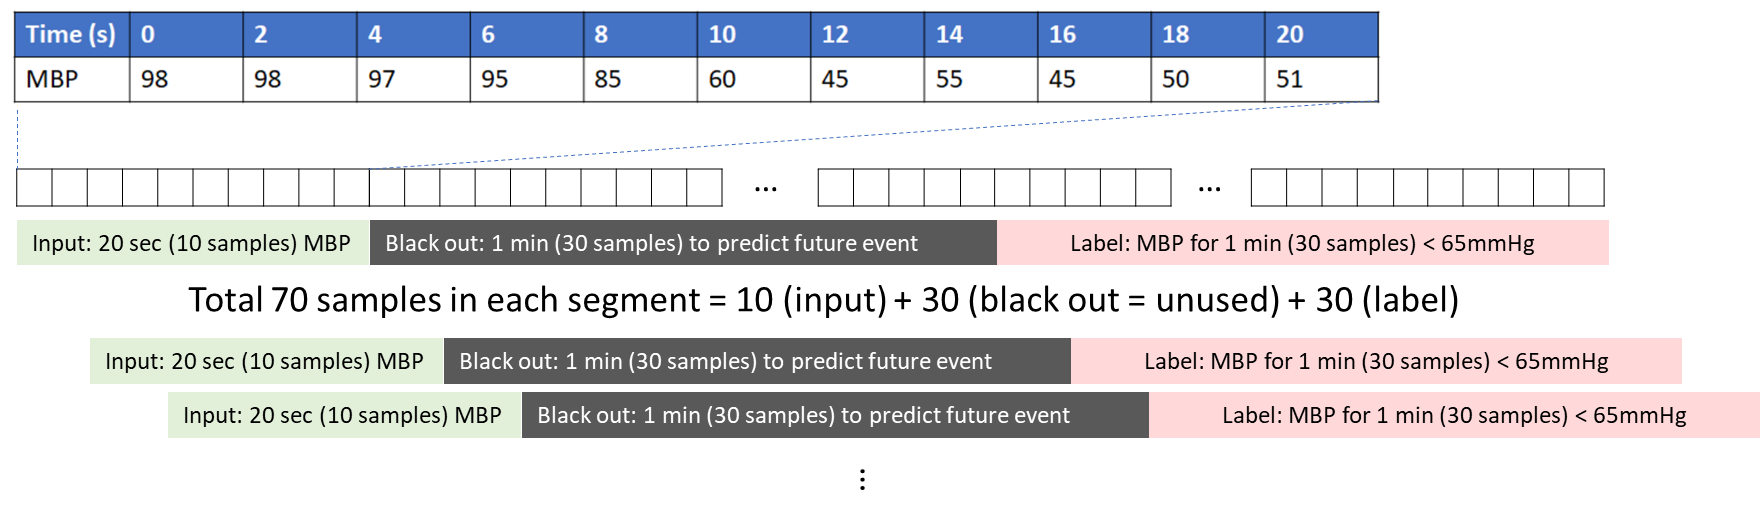

In [6]:
MINUTES_AHEAD = 1  # Predict hypotension 1 minutes ahead
LSTM_NODES = 16  # Number of cells in LSTM
BATCH_SIZE = 256  # Batch size for learning
MAX_CASES = 100  # Maximum number of cases for this example

# Final dataset for training and testing the model
x = []  # input with shape of (segements, timepoints)
y = []  # output with shape of (segments)
valid_mask = []  # validity of each segement
c = []  # caseid of each segment

# maximum number of cases
for caseid in caseids:
    print(f'loading {caseid}', end='...', flush=True)

    # read the mean blood pressure with 2 min interval
    mbps = vitaldb.load_case(caseid, ['Solar8000/ART_MBP'], 2)

    # a-line 연결 전 샘플들을 제거
    with np.errstate(invalid='ignore'):
        mbps[mbps < 40] = np.nan

    # 처음과 마지막의 결측값을 제거
    case_valid_mask = ~np.isnan(mbps)
    mbps = mbps[(np.cumsum(case_valid_mask) != 0) & (np.cumsum(case_valid_mask[::-1])[::-1] != 0)]

    # 중간 결측값을 직전값으로 대체
    mbps = pd.DataFrame(mbps).fillna(method='ffill').values.flatten()
    
    # event data 뽑음
    case_sample = 0
    case_event = 0
    # 입력 혈압 (20초 = 10샘플)
    # 중간 윈도우 (MINUTES_AHEAD * 30 샘플)
    # 결과 혈압 (1분 = 30샘플)
    for i in range(len(mbps) - (10 + MINUTES_AHEAD * 30 + 30)):
        segx = mbps[i:i + 10]

        # y는 mbp 기준
        segy = mbps[i + 10 + MINUTES_AHEAD * 30:i + 10 + MINUTES_AHEAD * 30 + 30]

        # 중간에 nan 있으면?
        valid = True
        if np.any(segx > 150):  # 어떤 샘플이든 150 이상이면?
            valid = False
        elif np.any(segy > 150):  # 어떤 샘플이든 150 이상이면?
            valid = False
        elif np.any(np.abs(np.diff(segx)) > 50):  # 2초만에 30 mmHg 이상 변하면
            valid = False
        elif np.any(np.abs(np.diff(segy)) > 50):  # 2초만에 30 mmHg 이상 변하면
            valid = False
        elif (segx < 40).all():  # 어떤 샘플이든 40 이하이면?
            valid = False
        elif (segy < 40).all():  # 어떤 샘플이든 40 이하이면?
            valid = False

        evt = np.nanmax(segy) < 65
        x.append(segx)  # 20초 segment
        y.append(evt)  # 최대 값이 65 미만이어야 함
        valid_mask.append(valid)
        c.append(caseid)
        
        if valid:
            case_sample += 1
            if evt:
                case_event += 1

    if case_sample > 0:
        print("{} samples {} ({:.1f} %) events".format(case_sample, case_event, 100*case_event/case_sample))
    else:
        print('all nan')

    if len(np.unique(c)) >= MAX_CASES:
        break

# final caseids
caseids = np.unique(c)

# 입력 데이터셋을 python array 에서 numpy array로 변경
x = np.array(x)[...,None]  # LSTM 에 입력으로 넣으려면 3차원으로 만들어야함
y = np.array(y) 
valid_mask = np.array(valid_mask)
c = np.array(c)

loading 3165...9520 samples 992 (10.4 %) events
loading 2503...3162 samples 0 (0.0 %) events
loading 3567...2880 samples 18 (0.6 %) events
loading 5809...10975 samples 525 (4.8 %) events
loading 2138...all nan
loading 13...4428 samples 102 (2.3 %) events
loading 629...13241 samples 2312 (17.5 %) events
loading 3621...7613 samples 318 (4.2 %) events
loading 2218...2436 samples 668 (27.4 %) events
loading 2392...7050 samples 0 (0.0 %) events
loading 2799...1542 samples 4 (0.3 %) events
loading 1508...all nan
loading 4739...5431 samples 303 (5.6 %) events
loading 657...7824 samples 107 (1.4 %) events
loading 2732...3340 samples 0 (0.0 %) events
loading 3782...6322 samples 1749 (27.7 %) events
loading 965...all nan
loading 1160...5924 samples 625 (10.6 %) events
loading 993...2876 samples 0 (0.0 %) events
loading 5780...16112 samples 146 (0.9 %) events
loading 3623...4859 samples 285 (5.9 %) events
loading 3196...7881 samples 0 (0.0 %) events
loading 3361...10939 samples 53 (0.5 %) events


## Splitting samples into training and testing dataset


In [7]:
ncase = len(caseids)
ntest = int(ncase * 0.2)
ntrain = ncase - ntest
caseids_train = caseids[:ntrain]
caseids_test = caseids[ncase - ntest:ncase]

# train set과 test set 으로 나눔
train_mask = np.isin(c, caseids_train)
test_mask = np.isin(c, caseids_test)

# invalid samples in test dataset is also needed for plotting
test_x = x[test_mask]
test_y = y[test_mask]
test_c = c[test_mask]

# only valid samples are required for the training dataset
train_x_valid = x[train_mask & valid_mask]
train_y_valid = y[train_mask & valid_mask]
test_x_valid = x[test_mask & valid_mask]
test_y_valid = y[test_mask & valid_mask]

testname = '{}cases {}ahead batchsize={} total {}, train {} ({} events {:.1f}%), test {} ({} events {:.1f}%)'.format(MAX_CASES, MINUTES_AHEAD, BATCH_SIZE, len(y), len(train_y_valid), sum(train_y_valid), 100*np.mean(train_y_valid), len(test_y_valid), sum(test_y_valid), 100*np.mean(test_y_valid))
testname

'100cases 1ahead batchsize=256 total 604550, train 456363 (21641 events 4.7%), test 115890 (3710 events 3.2%)'

## Model building and training

In [8]:
from keras.models import Sequential
from keras.models import Model, load_model
from keras.layers import Dense, LSTM, Input, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf

# making output folder
tempdir = 'output'
if not os.path.exists(tempdir):
    os.mkdir(tempdir)
weight_path = tempdir + "/weights.hdf5"

# build a model
model = Sequential()
model.add(LSTM(LSTM_NODES, input_shape=x.shape[1:]))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.AUC()])
hist = model.fit(train_x_valid, train_y_valid, validation_split=0.1, epochs=100, batch_size=BATCH_SIZE, class_weight={0:1, 1:5},
                 callbacks=[ModelCheckpoint(monitor='val_loss', filepath=weight_path, verbose=1, save_best_only=True),
                            EarlyStopping(monitor='val_loss', patience=2, verbose=0, mode='auto')])

# reload the best model
model.load_weights(weight_path)
open(tempdir + "/model.json", "wt").write(model.to_json())

Epoch 1/100
1605/1605 [==============================] - ETA: 0s - loss: 0.2750 - accuracy: 0.9319 - auc: 0.9562
Epoch 1: val_loss improved from inf to 0.06855, saving model to output/weights.hdf5
1605/1605 [==============================] - 20s 7ms/step - loss: 0.2750 - accuracy: 0.9319 - auc: 0.9562 - val_loss: 0.0686 - val_accuracy: 0.9714 - val_auc: 0.9596
Epoch 2/100
1604/1605 [============================>.] - ETA: 0s - loss: 0.2292 - accuracy: 0.9446 - auc: 0.9641
Epoch 2: val_loss did not improve from 0.06855
1605/1605 [==============================] - 14s 8ms/step - loss: 0.2292 - accuracy: 0.9445 - auc: 0.9641 - val_loss: 0.2213 - val_accuracy: 0.9133 - val_auc: 0.9609
Epoch 3/100
1603/1605 [============================>.] - ETA: 0s - loss: 0.2278 - accuracy: 0.9437 - auc: 0.9640
Epoch 3: val_loss did not improve from 0.06855
1605/1605 [==============================] - 9s 6ms/step - loss: 0.2278 - accuracy: 0.9437 - auc: 0.9640 - val_loss: 0.1728 - val_accuracy: 0.9333 - va

2125

## Evaluation of the model performance

In [9]:
from sklearn.metrics import auc, classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score, f1_score, precision_recall_curve

# make prediction on the test dataset
test_y_pred = model.predict(test_x_valid).flatten()

precision, recall, thmbps = precision_recall_curve(test_y_valid, test_y_pred)
auprc = auc(recall, precision)

fpr, tpr, thmbps = roc_curve(test_y_valid, test_y_pred)
auroc = auc(fpr, tpr)

thval = 0.5
f1 = f1_score(test_y_valid, test_y_pred > thval)
acc = accuracy_score(test_y_valid, test_y_pred > thval)
tn, fp, fn, tp = confusion_matrix(test_y_valid, test_y_pred > thval).ravel()

testres = 'auroc={:.3f}, auprc={:.3f} acc={:.3f}, F1={:.3f}, PPV={:.1f}, NPV={:.1f}, TN={}, fp={}, fn={}, TP={}'.format(auroc, auprc, acc, f1, tp/(tp+fp)*100, tn/(tn+fn)*100, tn, fp, fn, tp)
print(testres)

# rename final output folder
odir = testname + ' ' + testres
os.rename(tempdir, odir)

# auroc curve
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.savefig('{}/auroc.png'.format(odir))
plt.close()

# auprc curve
plt.figure(figsize=(10, 10))
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.savefig('{}/auprc.png'.format(odir))
plt.close()

auroc=0.964, auprc=0.478 acc=0.969, F1=0.440, PPV=51.8, NPV=98.0, TN=110861, fp=1319, fn=2291, TP=1419


## Plotting each case in the test dataset

5253	0.1963914537736309	


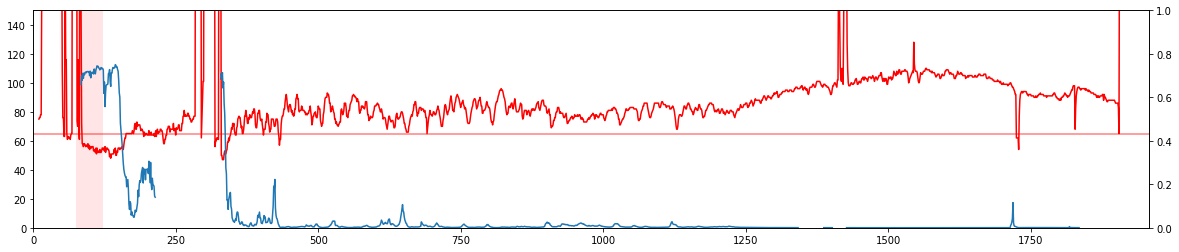

5310	0.07526464486152129	


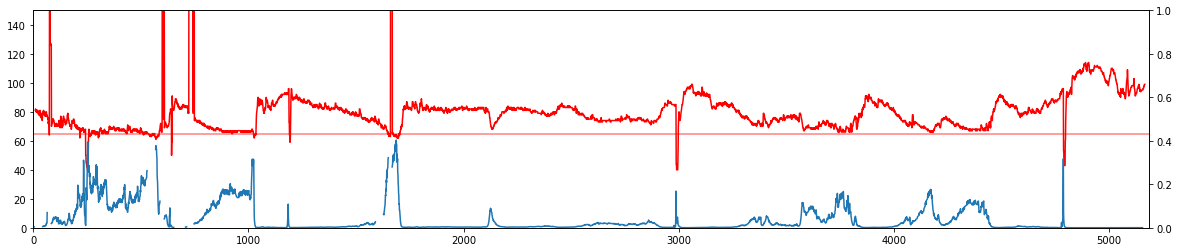

5397	0.09951627812595738	


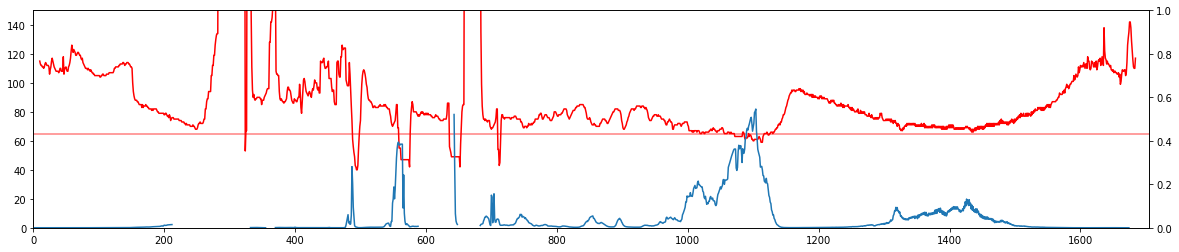

5456	0.07628367545625309	


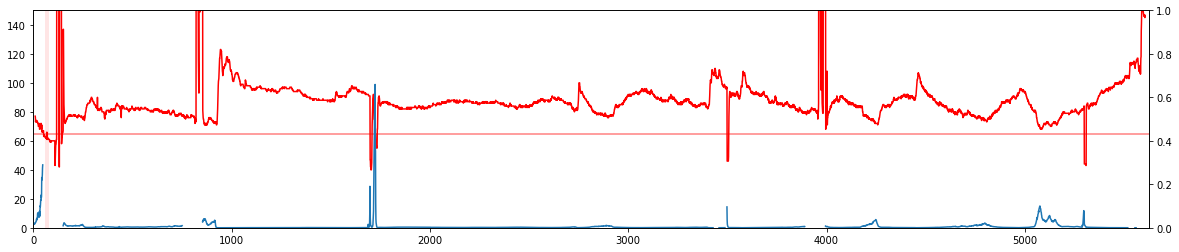

5509	0.007546236068868808	


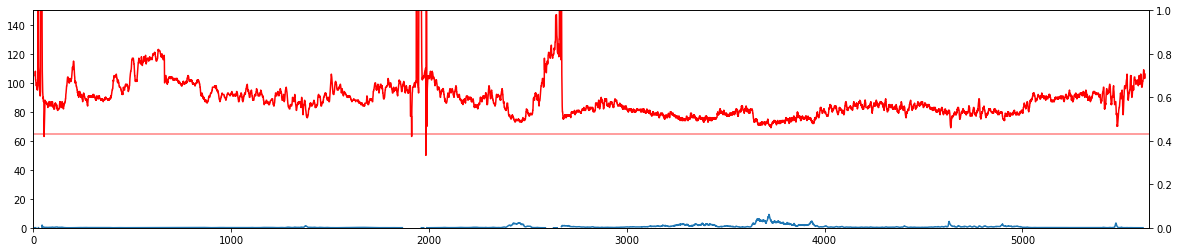

5526	0.21851827916486102	


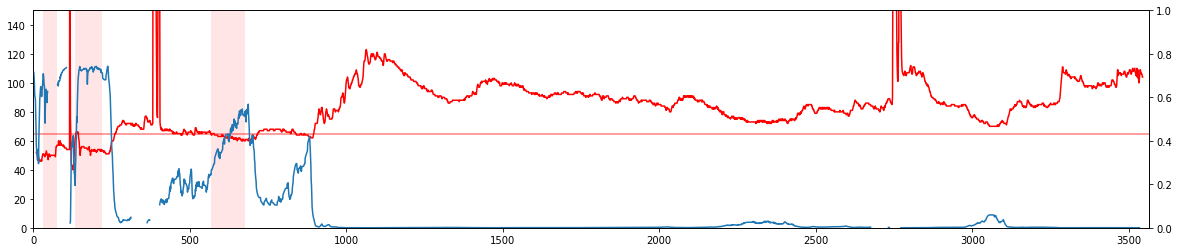

5561	0.0032005740573156343	


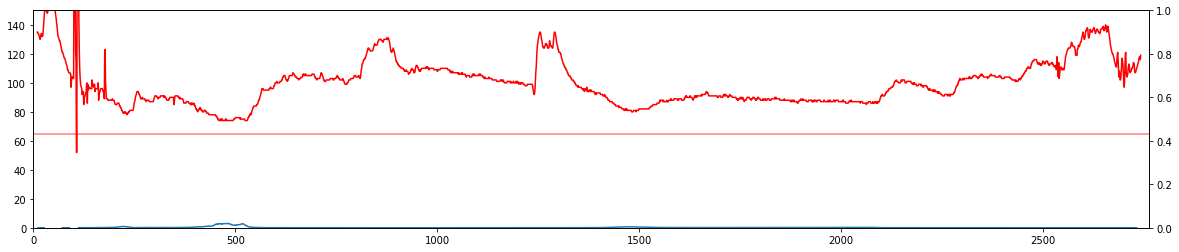

5571	0.004131515045568364	


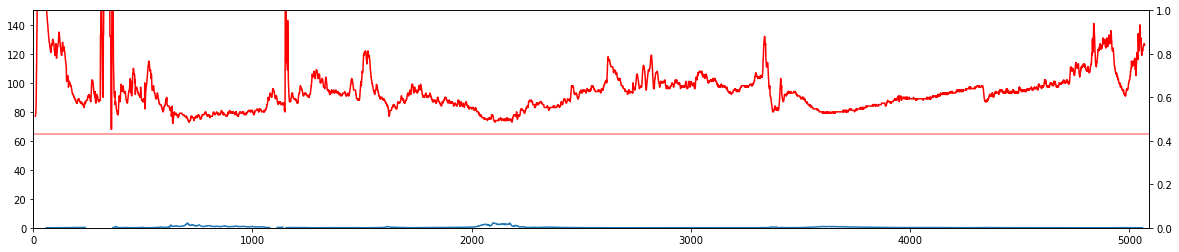

5582	0.23060863904630735	


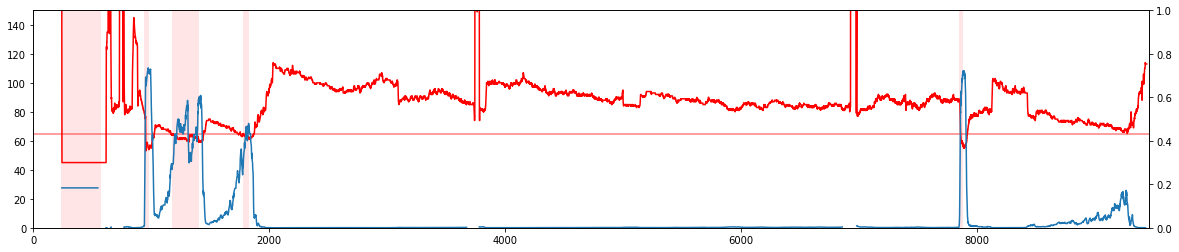

5680	0.03979661856000674	


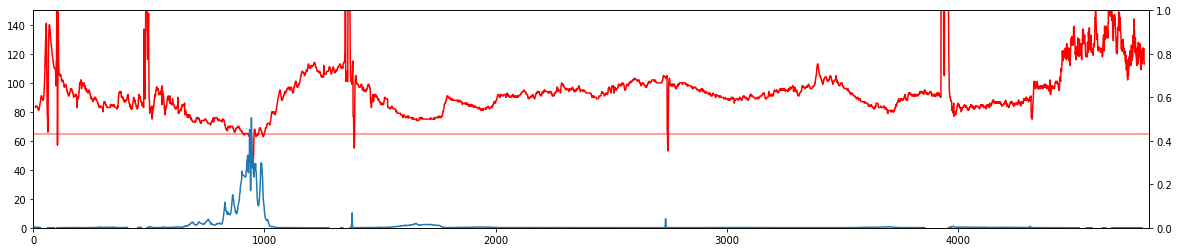

5780	0.10243911867887721	


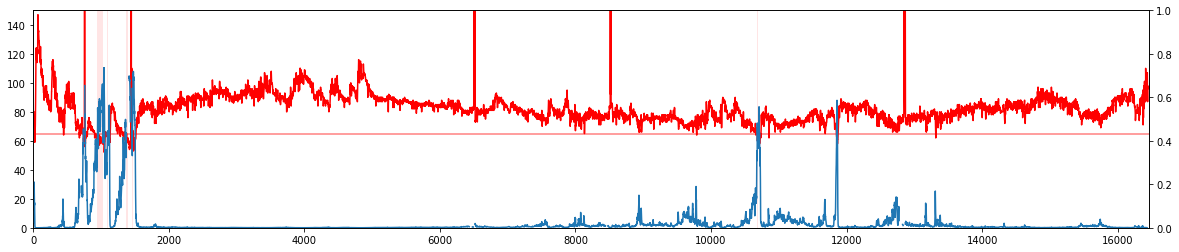

5809	0.14580804457972285	


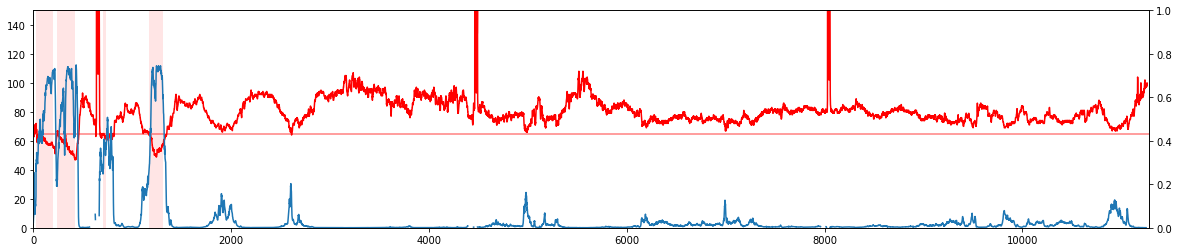

5951	0.014168575985854127	


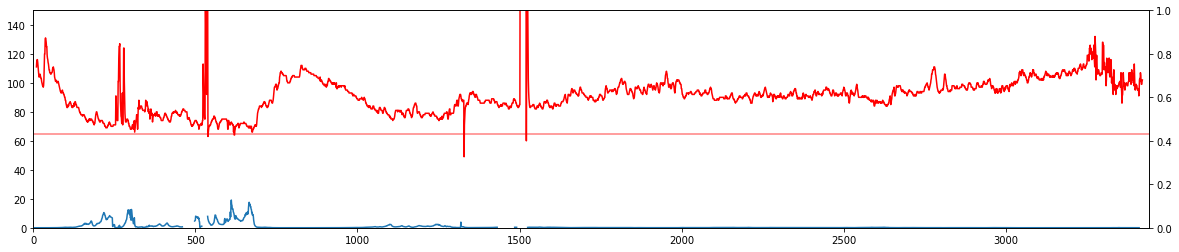

6120	0.04856331304028515	


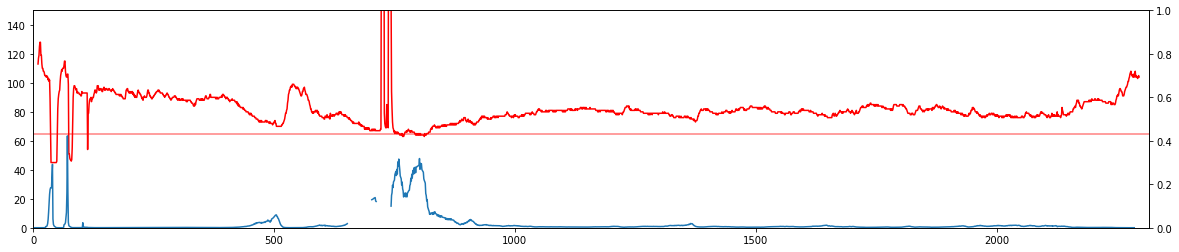

6132	0.2560504025494302	


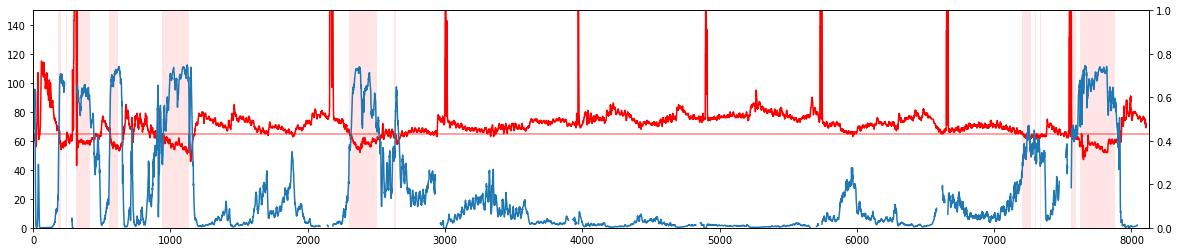

6143	0.03040872902941891	


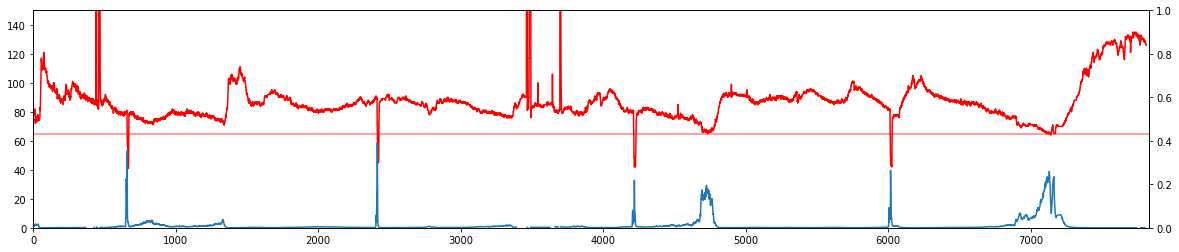

6217	0.2262414268587038	


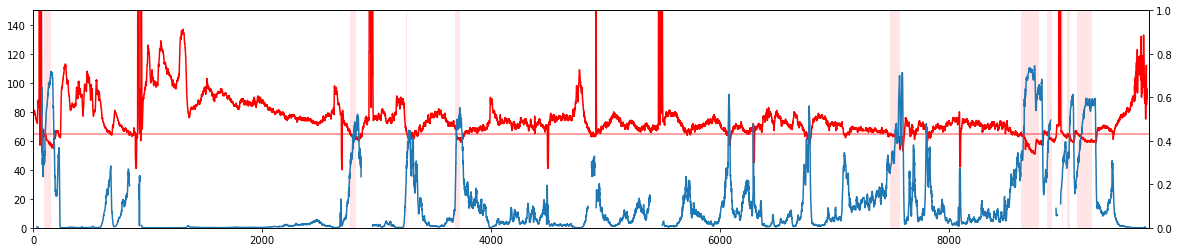

6230	0.05052274923812854	


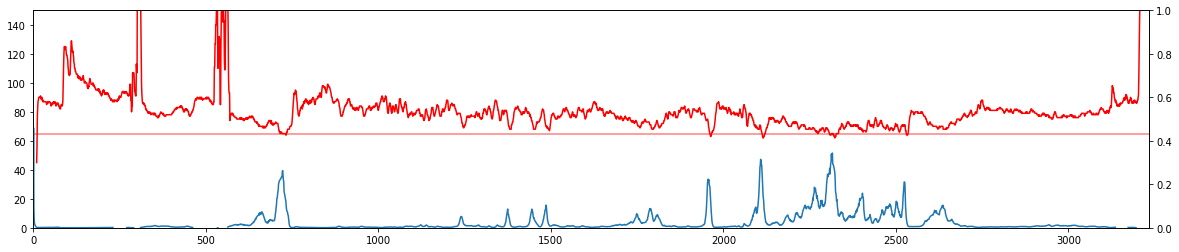

6264	0.014027963492525629	


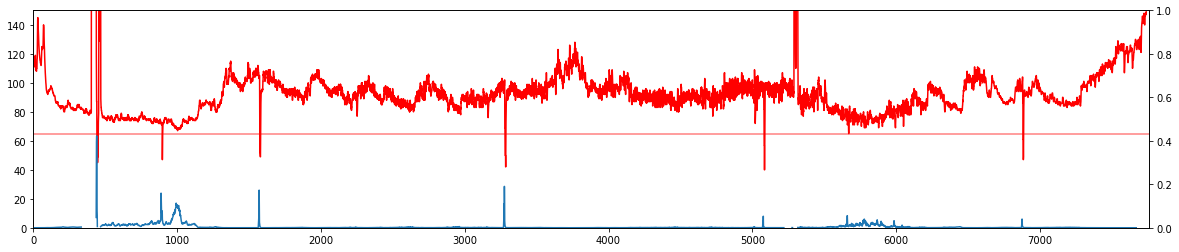

6282	0.24359047511299167	


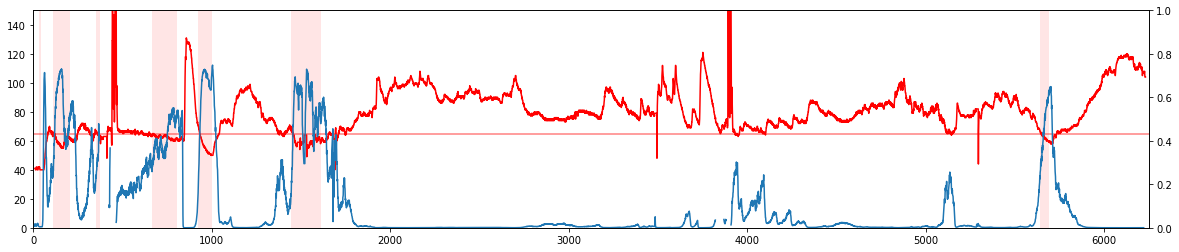

In [10]:
for caseid in caseids_test:
    case_mask = (c == caseid)
    case_len = np.sum(case_mask)
    if case_len == 0:
        continue

    case_x = x[case_mask]
    case_y = y[case_mask]
    case_valid_mask = valid_mask[case_mask]
    
    # calculate error for this case
    case_predy = model.predict(case_x).flatten()
    case_rmse = np.nanmean((case_y - case_predy) ** 2) ** 0.5
    print('{}\t{}\t'.format(caseid, case_rmse))

    # draw
    plt.figure(figsize=(20, 4))
    plt.xlim([0, case_len + MINUTES_AHEAD * 30])
    t = np.arange(0, case_len)

    # red bars for the event
    ax1 = plt.gca()
    for i in range(len(case_y)):
        if case_y[i]:
            ax1.axvspan(i + MINUTES_AHEAD * 30, i + MINUTES_AHEAD * 30 + 1, color='r', alpha=0.1, lw=0)

    # 65 mmHg bar
    ax1.axhline(y=65, color='r', alpha=0.5)
    ax1.plot(t + 10, case_x[:,-1], color='r')
    ax1.set_ylim([0, 150])

    ax2 = ax1.twinx()
    
    # draw valid samples
    case_predy[~case_valid_mask] = np.nan
    ax2.plot(t, case_predy)
    ax2.set_ylim([0, 1])
    
    # save
    plt.show()